In [230]:
# imports and downloads
from googlesearch import search
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.linear_model import LinearRegression

msft = 'MSFT Stock'
appl = 'APPL Stock'
goog = 'GOOG Stock'
snow = 'SNOW Stock'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tejcancode/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [231]:
url_1 = ('https://newsapi.org/v2/everything?'
       'q='+msft+'&'
       'from=2023-08-9&'
       'sortBy=new&'
       'apiKey=276500806ff849fb807fc4b51f2a490e')
response = requests.get(url_1).json()
articles = response.get('articles')[:6]
sentiment_store_msft = []
for i in articles:
    sentiment_store_msft.append(i['title'])
    sentiment_store_msft.append(i['description'])

In [232]:
url_2 = ('https://newsapi.org/v2/everything?'
       'q='+appl+'&'
       'from=2023-08-9&'
       'sortBy=new&'
       'apiKey=276500806ff849fb807fc4b51f2a490e')
response = requests.get(url_2).json()
articles = response.get('articles')[:6]
sentiment_store_appl = []
for i in articles:
    sentiment_store_appl.append(i['title'])
    sentiment_store_appl.append(i['description'])

In [233]:
url_3 = ('https://newsapi.org/v2/everything?'
       'q='+goog+'&'
       'from=2023-08-9&'
       'sortBy=popularity&'
       'apiKey=276500806ff849fb807fc4b51f2a490e')
response = requests.get(url_3).json()
articles = response.get('articles')[:6]
sentiment_store_goog = []
for i in articles:
    sentiment_store_goog.append(i['title'])
    sentiment_store_goog.append(i['description'])

In [234]:
url_4 = ('https://newsapi.org/v2/everything?'
       'q='+snow+'&'
       'from=2023-08-9&'
       'sortBy=new&'
       'apiKey=276500806ff849fb807fc4b51f2a490e')
response = requests.get(url_4).json()
articles = response.get('articles')[:6]
sentiment_store_snow = []
for i in articles:
    sentiment_store_snow.append(i['title'])
    sentiment_store_snow.append(i['description'])

In [235]:
tickers = yf.Tickers('msft aapl goog snow')

apple = tickers.tickers['AAPL'].history(period="1mo")
google = tickers.tickers['GOOG'].history(period="1mo")
microsoft = tickers.tickers['MSFT'].history(period="1mo")
snowflake = tickers.tickers['SNOW'].history(period="1mo")


In [236]:
sia = SentimentIntensityAnalyzer()
snow_score = sia.polarity_scores(str(sentiment_store_snow))
msft_score = sia.polarity_scores(str(sentiment_store_msft))
appl_score = sia.polarity_scores(str(sentiment_store_appl))
goog_score = sia.polarity_scores(str(sentiment_store_goog))
snow_2_score = -1 * snow_score['neg'] + snow_score['pos']
msft_2_score = -1 * msft_score['neg'] + msft_score['pos']
appl_2_score = -1 * appl_score['neg'] + appl_score['pos']
goog_2_score = -1 * goog_score['neg'] + goog_score['pos']
apple.drop(['Dividends', 'Stock Splits', 'Volume'], axis = 1, inplace = True)
microsoft.drop(['Dividends', 'Stock Splits'], axis = 1, inplace = True)
snowflake.drop(['Dividends', 'Stock Splits'], axis = 1, inplace = True)
google.drop(['Dividends', 'Stock Splits'], axis = 1, inplace = True)

In [237]:
apple['sia_score'] = appl_2_score
microsoft['sia_score'] = msft_2_score
snowflake['sia_score'] = snow_2_score
google['sia_score'] = goog_2_score

In [240]:
def mainfunction(company):
    
    prices = company['Open'].values
    additional_feature = X_apple['sia_score'].values[:-1] 

    returns = np.diff(prices) / prices[:-1]
    returns = returns.reshape(-1, 1)

    scaler_returns = StandardScaler()
    scaler_feature = StandardScaler()

    returns_scaled = scaler_returns.fit_transform(returns)
    additional_feature_scaled = scaler_feature.fit_transform(additional_feature.reshape(-1, 1))

    returns_tensor = torch.FloatTensor(returns_scaled)
    additional_feature_tensor = torch.FloatTensor(additional_feature_scaled)

    input_tensor = torch.cat((returns_tensor, additional_feature_tensor), dim=1)

    class StockPredictor(nn.Module):
        def __init__(self, input_size):
            super(StockPredictor, self).__init__()
            self.fc1 = nn.Linear(input_size, 64)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(64, 1)

        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x

    input_size = input_tensor.shape[1]
    model = StockPredictor(input_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    epochs = 100
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(input_tensor)
        loss = criterion(outputs, returns_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        next_day_return_scaled = model(input_tensor[-1]).reshape(-1, 1)
        next_day_return = scaler_returns.inverse_transform(next_day_return_scaled)

    previous_day_price = prices[-1]
    predicted_next_day_price = previous_day_price * (1 + next_day_return.item())

    print(f'Predicted Next Day Return: {next_day_return.item():.2f}')
    print(f'Predicted Next Day Open: {predicted_next_day_price:.2f}')
    
    return predicted_next_day_price, losses

In [241]:
apple_price, apple_losses = mainfunction(apple)
microsoft_price, msft_losses = mainfunction(microsoft)
google_price, googl_losses = mainfunction(google)
snowflake_price, snowflake_losses = mainfunction(snowflake)

Epoch [1/100], Loss: 1.0619
Epoch [2/100], Loss: 1.0357
Epoch [3/100], Loss: 1.0099
Epoch [4/100], Loss: 0.9845
Epoch [5/100], Loss: 0.9595
Epoch [6/100], Loss: 0.9348
Epoch [7/100], Loss: 0.9106
Epoch [8/100], Loss: 0.8867
Epoch [9/100], Loss: 0.8632
Epoch [10/100], Loss: 0.8400
Epoch [11/100], Loss: 0.8172
Epoch [12/100], Loss: 0.7948
Epoch [13/100], Loss: 0.7727
Epoch [14/100], Loss: 0.7510
Epoch [15/100], Loss: 0.7296
Epoch [16/100], Loss: 0.7086
Epoch [17/100], Loss: 0.6879
Epoch [18/100], Loss: 0.6676
Epoch [19/100], Loss: 0.6476
Epoch [20/100], Loss: 0.6280
Epoch [21/100], Loss: 0.6087
Epoch [22/100], Loss: 0.5898
Epoch [23/100], Loss: 0.5712
Epoch [24/100], Loss: 0.5530
Epoch [25/100], Loss: 0.5351
Epoch [26/100], Loss: 0.5176
Epoch [27/100], Loss: 0.5005
Epoch [28/100], Loss: 0.4837
Epoch [29/100], Loss: 0.4672
Epoch [30/100], Loss: 0.4511
Epoch [31/100], Loss: 0.4353
Epoch [32/100], Loss: 0.4199
Epoch [33/100], Loss: 0.4048
Epoch [34/100], Loss: 0.3901
Epoch [35/100], Loss: 0

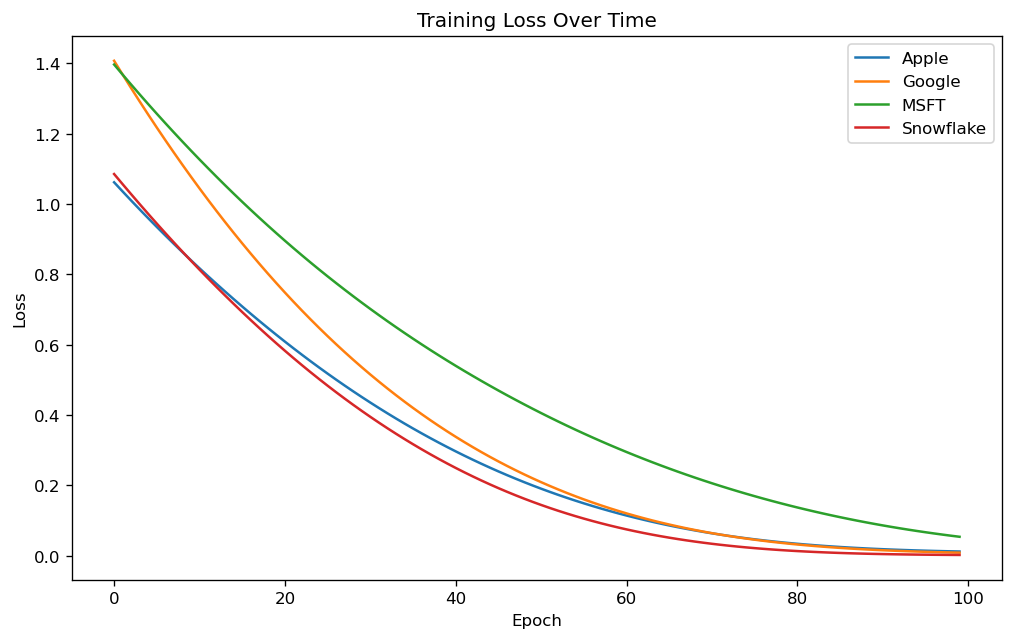

In [242]:
plt.figure(figsize=(10, 6), dpi=120) 
plt.plot(apple_losses, label='Apple')
plt.plot(googl_losses, label='Google')
plt.plot(msft_losses, label='MSFT')
plt.plot(snowflake_losses, label='Snowflake')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [200]:
tickers = yf.Tickers('msft aapl goog snow')

apple = tickers.tickers['AAPL'].history(period="1mo")['Open'][-1]
google = tickers.tickers['GOOG'].history(period="1mo")['Open'][-1]
microsoft = tickers.tickers['MSFT'].history(period="1mo")['Open'][-1]
snowflake = tickers.tickers['SNOW'].history(period="1mo")['Open'][-1]
apple_2 = tickers.tickers['AAPL'].history(period="1mo")[:-1]
google_2 = tickers.tickers['GOOG'].history(period="1mo")[:-1]
microsoft_2 = tickers.tickers['MSFT'].history(period="1mo")[:-1]
snowflake_2 = tickers.tickers['SNOW'].history(period="1mo")[:-1]

In [203]:
snowflake_2

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-07-12 00:00:00-04:00,175.089996,175.759995,170.220001,171.929993,4546900,0.0,0.0
2023-07-13 00:00:00-04:00,175.824997,184.449997,175.270004,184.220001,8873500,0.0,0.0
2023-07-14 00:00:00-04:00,184.940002,187.789993,180.070007,180.789993,5350500,0.0,0.0
2023-07-17 00:00:00-04:00,182.500000,185.580002,181.110001,184.210007,3675500,0.0,0.0
2023-07-18 00:00:00-04:00,185.479996,189.240005,182.100006,188.199997,4361100,0.0,0.0
2023-07-19 00:00:00-04:00,191.860001,193.229996,185.149994,185.449997,3933200,0.0,0.0
2023-07-20 00:00:00-04:00,182.470001,183.949997,175.550003,176.330002,6092900,0.0,0.0
2023-07-21 00:00:00-04:00,178.679993,180.809998,175.850006,175.899994,4017300,0.0,0.0
2023-07-24 00:00:00-04:00,176.110001,177.350006,172.860001,174.800003,3464800,0.0,0.0
